我们在上个教程中，学习到了UltraOpt的设计哲学是将优化器与评价器分离，如图所示:

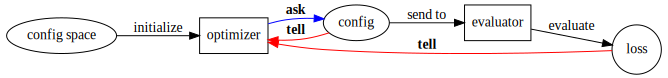

In [5]:
from graphviz import Digraph; g = Digraph()
g.node("config space", shape="ellipse"); g.node("optimizer", shape="box")
g.node("config", shape="ellipse"); g.node("loss", shape="circle"); g.node("evaluator", shape="box")
g.edge("config space", "optimizer", label="initialize"); g.edge("optimizer", "config", label="<<b>ask</b>>", color='blue')
g.edge("config","evaluator" , label="send to"); g.edge("evaluator","loss" , label="evaluate")
g.edge("config", "optimizer", label="<<b>tell</b>>", color='red'); g.edge("loss", "optimizer", label="<<b>tell</b>>", color='red')
g.graph_attr['rankdir'] = 'LR'; g